# Fundamental of Simulation Methods
**Name**: Maximilian Richter

**Matrikel Number**: 3463789

**Student ID**: hy455

## Problem Set 4: Collisionless systems and tree codes

In [57]:
import time
import numpy as np

# critical opening angle and smoothing length
theta_crit = 0.6
eps=0.01

In [58]:
# class for particle
class Particle:
    def __init__(self, pos, mass):

        self.pos  = pos.copy()
        self.mass = mass
    
        # vectors for the acceleration
        acc_tree  = None
        acc_exact = None

        

    def print_particle(self):
        print("particle properties")
        print("pos : ", self.pos)
        print("mass: ", self.mass)

In [3]:
# class for the nodes
class Node:
    def __init__(self, length, center):
        '''
        init function set length and centre of the node
        '''
        
        # vectors for center and centre of mass
        self.center = center.copy()
        self.cm     = [0.0,0.0,0.0]

        self.len    = length
        self.mass   = None

        self.node_count = 0
        
        # this data holds 8 sub-nodes, which can contain stars
        # oragnisation left/right in x, y, z
        self.stars  = [ [[None,None], [None,None]], [[None,None], [None,None]] ]
        
        self.particle = None


    def calculate_multipole_moments(self):
        '''
        here we calculate the multipole moments
        
        the function stores the information in the nodes, so no input or returns
        '''
        
        if self.stars[0][0][0] is not None: # do we have subnodes?
            # recursively compute the moments there
            for ix in range(2):
                for iy in range(2):
                    for iz in range(2):            
                        self.stars[ix][iy][iz].calculate_multipole_moments()
                        
            # reset own values and collect them from the subtree, which we just have processed
            self.mass = 0.0
            self.cm   = [0.0,0.0,0.0]
            
            # get total mass first
            for ix in range(2):
                for iy in range(2):
                    for iz in range(2):            
                        self.mass += self.stars[ix][iy][iz].mass

            # then use total mass to get cm
            for ix in range(2):
                for iy in range(2):
                    for iz in range(2):
                        for i in range(3):
                            self.cm[i] += self.stars[ix][iy][iz].cm[i] * \
                            self.stars[ix][iy][iz].mass / self.mass
        else:
            if self.particle is not None:
                self.mass = self.particle.mass
                for i in range(3):
                    self.cm[i] = self.particle.pos[i]
            else:
                # nothing there (empty node), set mass and cm to zero
                self.mass = 0.0
                self.cm   = [0.0,0.0,0.0]

                
    def get_opening_angle(self, pos):
        '''
        get the opening angle under which my current node appears for a given position pos
        input : pos
        return: angle
        
        Do a very crude approximation for the angle, no fancy geometry. Fancy stuff is not
        needed here because we typically accept only small angles for which sin(theta) = theta
        
        Add angle_epsilon to aviod division by zero in case of identical posisions
        '''
        
        angle_epsilon = 1e-30
        r2 = 0.0
        for i in range(3):
            r2 = r2 + (self.cm[i]-pos[i])**2
        return self.len / np.sqrt(r2 + angle_epsilon)
        
    def walk_tree(self, pos):
        '''
        walks the tree and computes accelerations at a given position
        
        input : pos: position to compute accelations for
        return: acc: vector with accelerations

        NOTE: assumes that we have computed the moments, in particular the mass!
              Checks for the mass as a proxy for where tree exists.
        '''
        
        acc = [0.0,0.0,0.0]

        if self.mass > 0.0:
            
            theta = self.get_opening_angle(pos)
            
            # need to check for a small opening angle or whether the node has a particle
            if (theta < theta_crit) or (self.particle is not None):
                # compute acceleration and done
                            
                # TO BE FILLED IN
                acc = self.mass/((self.cm - pos)**2 + eps**2)**(3/2)*(self.cm - pos)

                global node_count
                node_count += 1
                
            else:
                # angle too big or empty node
                if self.stars[0][0][0] is not None:
                    # there are subnodes, so do the three walk on them
                    for ix in range(2):
                        for iy in range(2):
                            for iz in range(2):
                                acc_loc = self.stars[ix][iy][iz].walk_tree(pos)
                                for i in range(3):
                                    acc[i] += acc_loc[i]
        return acc


    def print_node(self):
        print("node properties")
        print("center:", self.center)
        
    def insert_particle(self, particle):
        # check if this node has a particle, then it is a leaf
        # if it has no particle, then it might be empty or a node with subnodes
        
        if self.particle is not None:
            # subnode has particle, create new set of 8 nodes
            # and move particle to one of them
            ctr_new = [0.0,0.0,0.0]
            for ix in range(2):
                for iy in range(2):
                    for iz in range(2):
                        ctr_new[0] = self.center[0] + 0.25 * (2.0*ix-1.0) * self.len
                        ctr_new[1] = self.center[1] + 0.25 * (2.0*iy-1.0) * self.len
                        ctr_new[2] = self.center[2] + 0.25 * (2.0*iz-1.0) * self.len
                        len_new = 0.5*self.len
                        self.stars[ix][iy][iz] = Node(length=len_new, center=ctr_new)
                        
            idx = [0,0,0]
            for i in range(3):
                if self.particle.pos[i] < self.center[i]:
                    idx[i] = 0
                else:
                    idx[i] = 1
            # move local current particle to subnode idx)
            self.stars[idx[0]][idx[1]][idx[2]].particle = self.particle

            # set own particle to None
            self.particle = None
            
            # now check the new particle and try to insert it
            idx = [0,0,0]
            for i in range(3):
                if particle.pos[i] < self.center[i]:
                    idx[i] = 0
                else:
                    idx[i] = 1
            self.stars[idx[0]][idx[1]][idx[2]].insert_particle(particle)
        else:
            # no particle there, move it into correct subnode
            idx = [0,0,0]
            for i in range(3):
                if particle.pos[i] < self.center[i]:
                    idx[i] = 0
                else:
                    idx[i] = 1
            if self.stars[idx[0]][idx[1]][idx[2]] is not None:
                self.stars[idx[0]][idx[1]][idx[2]].insert_particle(particle)
            else:
                self.particle = particle

In [4]:
def get_particles(Npart):
    # create particles with random positions
    posx = np.random.uniform(size=Npart)
    posy = np.random.uniform(size=Npart)
    posz = np.random.uniform(size=Npart)
    # and a list that holds the particles
    p = []
    for i in range(Npart):
        p.append(Particle(pos=np.array([posx[i],posy[i],posz[i]]), mass=1.0))
    return p

In [5]:
def get_acceleration_tree(p):
    # measure time needed for tree
    start_time_tree = time.time()

    # create root node
    root = Node(length=1.0,center=[0.5,0.5,0.5])

    # insert particles into the tree
    for i in range(len(p)):
        root.insert_particle(p[i])   
        
    root.calculate_multipole_moments()

    global node_count
    node_count = 0

    interactions = []
    # do the treewalk for all particles
    for i in range(len(p)):
        p[i].acc_tree = root.walk_tree(p[i].pos)
        interactions.append(node_count)
        node_count = 0

    # done with tree computation
    stop_time_tree = time.time()
    return stop_time_tree - start_time_tree, np.mean(interactions)

def get_acceleration_direct(p):
    # do the exact acceleration via direct summation

    start_time_sum = time.time()

    # TO BE FILLED IN: EXACT SUMMATION
    #
    # loop over particles
    for i in range(len(p)):
        acc = 0
        for j in range(len(p)):
            acc += p[j].mass/((p[i].pos - p[j].pos)**2 + eps**2)**(3/2)*(p[i].pos - p[j].pos)
        p[i].acc_exact = - acc

    stop_time_sum = time.time()
    return stop_time_sum - start_time_sum

In [6]:
# number of particles
Npart=2000

p = get_particles(Npart)

time_tree, interactions = get_acceleration_tree(p)
time_sum = get_acceleration_direct(p) 

print("timing")
print("tree      :", time_tree)
print("summation :", time_sum)

# compute error
err_sum = 0.0
for i in range(len(p)):
    err_sum += np.sum(np.abs(p[i].acc_tree - p[i].acc_exact))

print("error", err_sum/Npart)
print("number of computations:", interactions)

timing
tree      : 6.789373159408569
summation : 31.497792720794678
error 489692.0002842549
number of computations: 171.8475


In [41]:
def get_eta(p):
    eta = []
    for i in range(len(p)):
        eta.append(np.linalg.norm(p[i].acc_tree - p[i].acc_exact)/np.linalg.norm(p[i].acc_exact))
    return np.mean(eta)

print("eta =", get_eta(p))

eta = 14.593160487355394


In [10]:
N_list = [500,1000,2000,4000]
theta_list = [0.2, 0.4, 0.8]

time_array_tree = np.zeros((4,3))
time_array_sum = np.zeros((4,3))

eta_array = np.zeros((4,3))
interaction_array = np.zeros((4,3))

for i,Npart in enumerate(N_list):
    p = get_particles(Npart)
    time_sum = get_acceleration_direct(p)
    for j,theta_crit in enumerate(theta_list):
        print(f"Particles: {Npart}, Opening Angle: {theta_crit}")
        time_tree, interactions = get_acceleration_tree(p)
        eta = get_eta(p)

        time_array_sum[i,j] = time_sum
        time_array_tree[i,j] = time_tree 

        eta_array[i,j] = eta
        interaction_array[i,j] = interactions


Particles: 500, Opening Angle: 0.2
Particles: 500, Opening Angle: 0.4
Particles: 500, Opening Angle: 0.8
Particles: 1000, Opening Angle: 0.2
Particles: 1000, Opening Angle: 0.4
Particles: 1000, Opening Angle: 0.8
Particles: 2000, Opening Angle: 0.2
Particles: 2000, Opening Angle: 0.4
Particles: 2000, Opening Angle: 0.8
Particles: 4000, Opening Angle: 0.2
Particles: 4000, Opening Angle: 0.4
Particles: 4000, Opening Angle: 0.8


In [11]:
import pandas as pd

df = pd.DataFrame(time_array_tree, columns = [f"theta={theta_list[0]}", f"theta={theta_list[1]}", f"theta={theta_list[2]}"],
                  index = [f"N={N_list[0]}", f"N={N_list[1]}", f"N={N_list[2]}", f"N={N_list[3]}"]) 

print("Times Tree")
display(df)

Times Tree


,theta=0.2,theta=0.4,theta=0.8
N=500,3.447360,1.587538,0.475472
N=1000,12.150112,4.839048,1.297208
N=2000,37.127806,12.408325,3.135413
N=4000,110.157446,32.750958,7.668933


In [12]:
df = pd.DataFrame(time_array_sum, columns = [f"theta={theta_list[0]}", f"theta={theta_list[1]}", f"theta={theta_list[2]}"],
                  index = [f"N={N_list[0]}", f"N={N_list[1]}", f"N={N_list[2]}", f"N={N_list[3]}"]) 

print("Times sum")
display(df)

Times sum


,theta=0.2,theta=0.4,theta=0.8
N=500,2.159276,2.159276,2.159276
N=1000,7.420989,7.420989,7.420989
N=2000,30.116721,30.116721,30.116721
N=4000,118.953046,118.953046,118.953046


In [13]:
df = pd.DataFrame(eta_array, columns = [f"theta={theta_list[0]}", f"theta={theta_list[1]}", f"theta={theta_list[2]}"],
                  index = [f"N={N_list[0]}", f"N={N_list[1]}", f"N={N_list[2]}", f"N={N_list[3]}"]) 

print("Eta")
display(df)

Eta


,theta=0.2,theta=0.4,theta=0.8
N=500,1.058200,2.444361,5.088789
N=1000,1.648813,3.443467,7.393828
N=2000,2.436317,4.802798,9.598453
N=4000,3.971109,7.522312,14.593160


In [14]:
df = pd.DataFrame(interaction_array, columns = [f"theta={theta_list[0]}", f"theta={theta_list[1]}", f"theta={theta_list[2]}"],
                  index = [f"N={N_list[0]}", f"N={N_list[1]}", f"N={N_list[2]}", f"N={N_list[3]}"]) 

print("Interactions")
display(df)

Interactions


,theta=0.2,theta=0.4,theta=0.8
N=500,387.3200,191.33800,58.8540
N=1000,656.6980,284.44900,77.0620
N=2000,1030.1620,368.78550,90.5225
N=4000,1555.4215,472.24875,106.9915


## (d) Make a plot

I used a linear regression model in the normal space (not log) because in the log it does not have any linearity. Maybe this is because of python caching stuff so not the true $O(N\log N)$ behaviour is seen. Its much faster than direct summation though. For the direct summation i used a quadratic one because of the $O(N^2)$ 

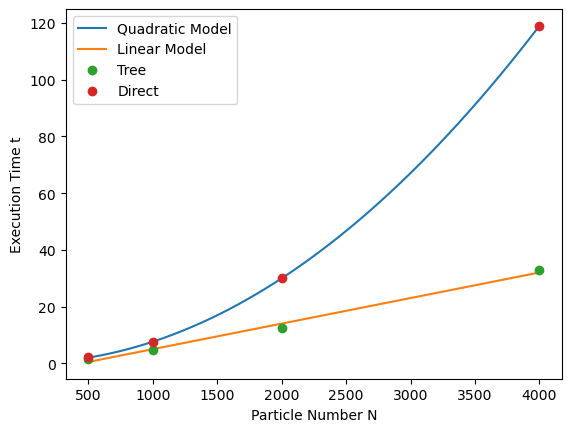

In [54]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def linear(x,m,b):
    return m*x+b

def quadratic(x,a,b,c):
    return a*x**2+b*x+c

popt_quadratic,pcov = curve_fit(quadratic, N_list, time_array_sum[:,1])

lin = np.linspace(N_list[0], N_list[-1], 100)
model = quadratic(lin, *popt_quadratic)
plt.plot(lin, model, label="Quadratic Model")


popt_linear,pcov = curve_fit(linear, N_list, time_array_tree[:,1])

lin = np.linspace(N_list[0], N_list[-1], 100)
model = linear(lin, *popt_linear)

plt.plot(lin, model, label="Linear Model")
plt.plot(N_list, time_array_tree[:,1], "o", label="Tree")
plt.plot(N_list, time_array_sum[:,1], "o", label="Direct")
plt.xlabel("Particle Number N")
plt.ylabel("Execution Time t")
plt.legend()
#plt.yscale("log")



In [56]:
print(f"Time for 10^10 particles with Tree: {linear(10**10, *popt_linear)/60/60/24/365:.3} years")
print(f"Time for 10^10 particles with Sum: {quadratic(10**10, *popt_quadratic)/60/60/24/365:.3} years")

Time for 10^10 particles with Tree: 2.86 years
Time for 10^10 particles with Sum: 2.34e+07 years
